# Conv Net

In [1]:
%load_ext tensorboard

from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Install SimpleITK
!pip install SimpleITK
# Install tf-nightly
# !pip install tf-nightly

In [2]:
import tensorflow as tf

print(tf.version)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>
Num GPUs Available:  1


In [3]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

## Image resize/rescale

(160, 160, 150)


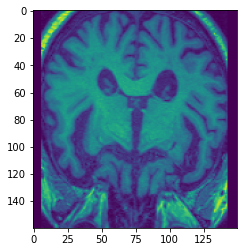

In [5]:
import SimpleITK as sitk

import matplotlib.pyplot as plt

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))

np_image = sitk.GetArrayFromImage(image)
print(np_image.shape)
plt.imshow(np_image[80])

(160, 160, 150)
(80, 80, 65)
(112, 112, 105)


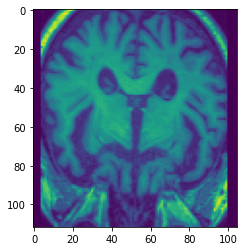

In [6]:
from matplotlib import pyplot as plt
from skimage.transform import resize, rescale

# new_img = np_image[:, :, 10:140]
new_img = np_image
print(new_img.shape)

resized = resize(new_img, (80, 80, 65))
print(resized.shape)

rescaled = rescale(new_img, 0.7)
print(rescaled.shape)

plt.imshow(resized[40, :, :])
plt.imshow(rescaled[int(80 * 0.7), :, :])

## Image Batch Reading

In [7]:
len(os.listdir(saliencies_and_segmentations_v2_path))

502

In [4]:
import os
import math

import numpy as np
import SimpleITK as sitk

from keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize


def process_image(path, input_shape):
    return resize(sitk.GetArrayViewFromImage(sitk.ReadImage(path)), input_shape[:3]).reshape(input_shape)


# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class MRISequence(Sequence):
    def __init__(self, path, batch_size, input_shape, classes=['AD', 'CN']):
      self.encoder = LabelEncoder()
      self.encoder.fit(np.array(classes))
      self.input_shape = input_shape

      self.batch_size = batch_size
      self.images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
        
    def __len__(self):
        return math.ceil(len(self.images_dirs) / self.batch_size)

    def __getitem__(self, idx):
        images_dirs = self.images_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if not len(images_dirs):
          return np.array([]).reshape(-1, input_shape), np.array([]).reshape(-1, input_shape)

        batch_x = np.array([process_image(os.path.join(image_dir, 'data.nii'), self.input_shape) for image_dir in images_dirs])
        batch_y = self.encoder.transform(np.array([self.__readfile(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs]))

        return batch_x, batch_y

    def __readfile(self, file_path):
        fo = open(file_path, "r")
        c = fo.readline()
        fo.close()
        return c

    def getitem(self, idx):
      return self.__getitem__(idx)

In [9]:
path = saliencies_and_segmentations_v2_path
encoder = LabelEncoder()
encoder.fit(np.array(['AD', "CN"]).reshape(-1, 1))
images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
images_dirs = images_dirs[:32]

def read_file(file_path):
  fo = open(file_path, "r")
  c = fo.readline()
  fo.close()
  return c

batch_y = np.array([read_file(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
encoder.transform(batch_y)

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1])

In [11]:
# saliances = [sitk.ReadImage(os.path.join(image_dir, 'data.nii')) for image_dir in images_dirs]
# np.array([sitk.GetArrayViewFromImage(raw_image).reshape((160, 160, 150, 1)) for raw_image in saliances])

In [12]:
seq = MRISequence(saliencies_and_segmentations_v2_path, 4, input_shape=(160, 160, 150, 1))

x, y = seq.getitem(1)
print(x.shape, y.shape)

(4, 160, 160, 150, 1) (4,)


## Train/Test split

In [5]:
import os
import time
import shutil

from tqdm import tqdm


def train_test_split(src, dst, **kwargs):
  split = kwargs.get('split', (0.8, 0.1, 0.1))
  dirname = kwargs.get('dirname', str(int(time.time())))

  if len(split) != 3:
    raise "split mus be length of three!"

  if sum(split) != 1:
    raise "sum of split must be 1!"

  dst_dir = os.path.join(dst, f'{dirname}')
  train_dir = os.path.join(dst_dir, 'train')
  test_dir = os.path.join(dst_dir, 'test')
  val_dir = os.path.join(dst_dir, 'val')
  
  if os.path.exists(dst_dir):
    print("not copying files since the destination directory already exists")

    return train_dir, test_dir, val_dir

  os.mkdir(dst_dir)
  print(f"copying to {dst_dir}...\n")

  # list of directories to copy
  src_dirs = os.listdir(src)

  src_dirs_count = len(src_dirs)
  for idx, dir in tqdm(enumerate(src_dirs), total=src_dirs_count):
    dst_dir = train_dir

    if idx > split[0] * src_dirs_count:
      dst_dir = test_dir
    if idx > (split[0] + split[1]) * src_dirs_count:
      dst_dir = val_dir

    shutil.copytree(os.path.join(src, dir), os.path.join(dst_dir, dir))

  return train_dir, test_dir, val_dir


# train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/')

## 3D CNN

https://web.stanford.edu/~eadeli/publications/MICCAI_DeepAD_Final.pdf

In [14]:
import tensorflow as tf
import os

USE_TPU = False

if USE_TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)

  print("All devices: ", tf.config.list_logical_devices('TPU'))

In [6]:
from keras import Sequential
from keras.layers import Conv3D, MaxPool3D, Dense, Flatten, Dropout
from keras.regularizers import L2


def create_model():
  # In the original paper, they experiment with dropout and L2 regularizers
  # they do not specify, where they put dropout layers, and on which layers they
  # apply what types of regularizations
  beta = 0.01

  model = Sequential()

  # L1, L2
  # In the original paper they use input_shape=(116, 113, 83, 1), however it does not match
  # the proportions of our input shape
  model.add(Conv3D(32, kernel_size=3, activation='relu', activity_regularizer=L2(beta), input_shape=(112, 112, 105, 1)))
  model.add(Conv3D(32, kernel_size=3, activation='relu', activity_regularizer=L2(beta)))

  # L3
  model.add(MaxPool3D(pool_size=(2, 2, 2)))

  # Dropout
  model.add(Dropout(0.25))

  # L4, L5
  model.add(Conv3D(64, kernel_size=3, activation='relu', activity_regularizer=L2(beta)))
  model.add(Conv3D(64, kernel_size=3, activation='relu', activity_regularizer=L2(beta)))

  # L6
  model.add(MaxPool3D(pool_size=(3, 3, 3)))

  # Dropout
  model.add(Dropout(0.25))

  # L7, L8
  model.add(Conv3D(128, kernel_size=3, activation='relu', activity_regularizer=L2(beta)))
  model.add(Conv3D(128, kernel_size=3, activation='relu', activity_regularizer=L2(beta)))

  # L9
  model.add(MaxPool3D(pool_size=(4, 4, 4)))

  # Dropout
  model.add(Dropout(0.25))

  # Flatten
  model.add(Flatten())

  # L10
  model.add(Dense(512, activity_regularizer=L2(beta)))

  # L11
  model.add(Dense(256, activity_regularizer=L2(beta)))

  # Output
  model.add(Dense(2, activation='softmax'))

  # Finally compile the model!
  model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    metrics=["accuracy"]
  )

  return model

In [7]:
import datetime


def train(model):
  global CHECKPOINT_DIRECTORY
  global LOG_DIRECTORY

  model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  print(f'model key: {model_key}')

  checkpoint_dir = os.path.join(CHECKPOINT_DIRECTORY, model_key)
  log_dir = os.path.join(LOG_DIRECTORY, model_key)

  print(f'checkpoint dir - {checkpoint_dir}')
  print(f'log dir - {log_dir}')

  callbacks = [
      tf.keras.callbacks.TensorBoard(
          log_dir=os.path.join(log_dir, str(datetime.datetime.now())),
          histogram_freq=1,
          profile_batch=0
      ),
      tf.keras.callbacks.ModelCheckpoint(
          os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt'),
          monitor='val_loss',
          verbose=0,
          save_best_only=True,
          mode='auto'
      ),
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping 
      tf.keras.callbacks.EarlyStopping(
          monitor='loss',
          patience=3 # Number of epochs with no improvement after which training will be stopped.
      )
  ] 

  # train the model
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
  print('training...')
  model.fit(
      train_seq,
      epochs=50,
      workers=1,
      verbose=1,
      callbacks=callbacks
  )

  print('loading best model...')
  latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(latest_checkpoint_path)
  print('best model loaded!')

In [8]:
import datetime

# https://github.com/timzatko/fiit-nsiete/blob/master/src/model.py

# constants
LOG_DIRECTORY = os.path.join('logs')
CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'checkpoints')

# get paths to data
train_dir, test_dir, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', dirname='1603829908')

# set the batch size
batch_size = 2
input_shape = (112, 112, 105, 1)

# initialize sequence
train_seq = MRISequence(train_dir, batch_size, input_shape=input_shape)
val_seq = MRISequence(val_dir, batch_size, input_shape=input_shape)

not copying files since the destination directory already exists


In [9]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 110, 110, 103, 32) 896       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 108, 108, 101, 32) 27680     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 54, 54, 50, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 50, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 52, 52, 48, 64)    55360     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 50, 50, 46, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 16, 15, 64)    0

In [19]:
# TPU Support
# https://towardsdatascience.com/how-to-colab-with-tpu-98e0b4230d9c
# strategy = tf.distribute.TPUStrategy(resolver)

if USE_TPU:
  with strategy.scope():
      model = create_model()
      train(model)

In [ ]:
train(model)

model key: 20201027-230955
checkpoint dir - /content/gdrive/My Drive/checkpoints/20201027-230955
log dir - logs/20201027-230955
training...
Epoch 1/50
  9/201 [>.............................] - ETA: 21:46 - loss: 0.6931 - accuracy: 0.6111

In [ ]:
val_seq = MRISequence(val_dir, batch_size, input_shape=input_shape)

x, y = val_seq.getitem(0)
print(x.shape, y.shape)

In [23]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/gpu.ipynb#scrollTo=hPI--n_jhZhv
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU
